In [1]:
import findspark

findspark.init()

In [2]:
import time

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession

sc = SparkContext("local[2]", appName='Streaming-Test-1')

## 10 seconds for dividing into batches
ssc = StreamingContext(sc, 10)
sqlcontext =  SparkSession(sc)

host = 'localhost'
port = 3090 ## same port as listener

## Create an input from TCP source hostname:port. Data is received 
# ## using a TCP socket and receive byte is interpreted as UTF8 encoded \n delimited lines.
socket_stream = ssc.socketTextStream(host, port)
lines = socket_stream.window(20) ## perform transformation for 20 seconds window of each 10 seconds interval

## function for creating tuples
def list_to_tup(x):
    item = x.split('::::')
    return (item[0], item[1], item[2])

## registers to a table
# lines.map(lambda x: list_to_tup(x)).foreachRDD(lambda rdd: rdd.toDF().registerTempTable('temporary'))
lines.map(list_to_tup).map(lambda x: (x[0], int(x[2]))).reduceByKey(lambda a, b: a + b).foreachRDD(lambda rdd: rdd.toDF().createOrReplaceTempView('temporary'))

Run `listener.py`

In [3]:
ssc.start()

## wait for at least 1 min for temporary table to be created
time.sleep(60) 

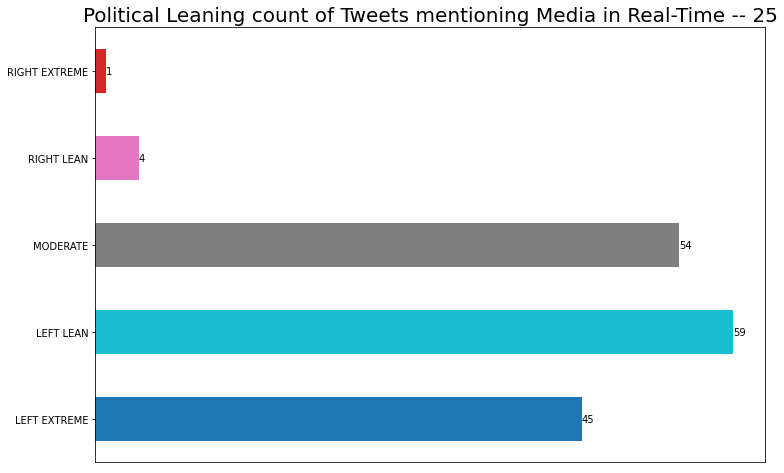

In [4]:
import matplotlib.pyplot as plt

from IPython import display
## output to console
%matplotlib inline

## convert data values to char
def politicalBias(x):
    if x <= -2:
        return 'LEFT EXTREME'
    elif x == -1:
        return 'LEFT LEAN'
    elif x >= 2:
        return "RIGHT EXTREME"
    elif x == 1:
        return 'RIGHT LEAN'
    else:
        return 'MODERATE'

counter = 0 ## track loop
while True:
    try:
        ## PROCESS DATA FRAME
        temp = sqlcontext.sql('SELECT * FROM temporary')
        df = temp.toPandas()
        df['LEANING'] = df['_2'].apply(lambda x: politicalBias(x))
        series = df['LEANING'].value_counts()
        series = series.reindex(['LEFT EXTREME', 'LEFT LEAN', 'MODERATE', 'RIGHT LEAN', 'RIGHT EXTREME'])

        display.clear_output(wait=True) ## clear output when update
        ## process figures
        _ = plt.figure(figsize=(12, 8))
        ax = series.plot.barh(color = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:pink' ,'tab:red'])
        _ = ax.bar_label(ax.containers[0])
        _ = plt.xticks([]) 
        _ = plt.title(f'Political Leaning count of Tweets mentioning Media in Real-Time -- {counter}', size=20)
        _ = plt.savefig(f'.\\temporaryFig\\NUM_{counter}_PLOT.png')
        _ = plt.show()

        counter += 1 ## increment
        continue

    except Exception as err:
        print(err)
        break

In [ ]:
ssc.stop()